<a href="https://colab.research.google.com/github/jaotheboss/ESG-Disclosure-Analysis/blob/main/Main_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Analysis for DSA4264

**Task**:
Explore the relationship between a firm's environmental disclosure and financial performance. 


**Tasks**:
1. Extract out the text data of the firms that have available financial metrics
2. Filter out the environmental disclosures (sentence that contains the keywords or n-grams) from the text data
3. Concatenate all the sentences from each document and have each document form the observations of a corpus
4. Perform LDA or STM on the corpus
5. Analyse the results:
    
    - Between rating 1 and 5
    - Across the years
    - Both

## Setting up the modules and functions

In [1]:
# setting up the work directory
import os 
os.chdir('/content/drive/My Drive/School/NUS/Year 4 Sem 1/DSA4264/(TSX) Toronto')

!pip install pyLDAvis
!pip install pdfplumber

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
import pdfplumber
import multiprocessing as mp

In [2]:
# defining functions
def _PREPROCESS(text, min_char_len = 3, max_char_len = 15):
    """
    Function:     Preprocesses and cleans text
                    
    Input:        Text array
    
    Returns:      A column of processed text
    """
    contractions = {
            "ain't": "am not / are not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is",
            "i'd": "I had / I would",
            "i'd've": "I would have",
            "i'll": "I shall / I will",
            "i'll've": "I shall have / I will have",
            "i'm": "I am",
            "i've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"}

    def contract(text):
        for word in text.split():
            if word.lower() in contractions:
                text = text.replace(word, contractions[word.lower()])
        return text
    
    def preprocess(text):
        # throw away numbers
        text = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z]+", ' ', str(text).lower()).strip() 
        doc = nlp(text)
        text = [token.lemma_ for token in doc if token.is_stop == False and len(token) >= min_char_len and len(token) <= max_char_len]
        new_text = ' '.join(text)
        return new_text
       
    text = text.apply(contract).apply(preprocess)
    return text

def extract_pdf_text(file_name, min_sent_len = 10):
    doc = []
    try:
        with pdfplumber.open(file_name) as pdf:
            pages = pdf.pages
            for i in pages:
                page = i.extract_text()
                if page:
                    doc.extend([sentence.string for sentence in nlp(page).sents if len(sentence.text.split()) >= min_sent_len])
    except:
        doc.extend(['Unrecognized PDF!!!'])
    doc = _PREPROCESS(pd.Series(doc))
    return doc

def get_top_k(df, vectorizer, k = 10):
       """get top k occuring words"""
       vectorizer.fit(df)
       counts = pd.DataFrame(vectorizer.transform(df).toarray())
       counts.columns = vectorizer.get_feature_names()
       counts = counts.apply(sum).sort_values(ascending = False)[:k]
       sns.barplot(x = counts.values, y = counts.index)

def display_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_words.append(top_words)
        print(", ".join(top_words))
        print()
    return topic_words

def topic_classification(model, vectorized_text, dataset):
    topic_labels = np.argmax(vectorized_text.toarray() @ model.components_.T, axis = 1)
    dataset['topic_labels'] = topic_labels
    return dataset

def summary_layout(*lsts):
    n_topics = len(lsts[0])
    for i in range(n_topics):
        str2print = 'topic ' + str(i) + '\n'
        for group in lsts:
            str2print += ', '.join(group[i])
            str2print += '\n'
        print(str2print)
        print()

## Preprocessing

In [13]:
# getting the file names
metadata = pd.read_csv('clustered_files_cleaned.csv')
def quantiles(arr):
    result = []
    quads = [np.quantile(arr, 0.25*i) for i in range(1, 4)]
    for i in arr:
        if i <= quads[0]:
            result.append(1)
        elif i <= quads[1]:
            result.append(2)
        elif i <= quads[2]:
            result.append(3)
        else:
            result.append(4)
    return result
for year in metadata.fileyear.unique():
    metadata.loc[metadata.fileyear == year, 'rating_quarters'] = quantiles(metadata.loc[metadata.fileyear == year, 'earnings'])
metadata

,name,fileyear,finalfilename,ticker,earnings,rating,rating_quarters
0,Absolute Software Corp,2018,TSX_7376__Absolute Software Corp___Active____(...,ABT,3.687000e+09,5.0,4.0
1,Acasta Enterprises Inc,2018,TSX_7299__Acasta Enterprises Inc___Active____(...,AEF,7.850061e+07,3.0,2.0
2,AcuityAds Holdings Inc,2018,TSX_7319__AcuityAds Holdings Inc___Active____(...,AT,-4.260000e+07,1.0,1.0
3,Aecon Group Inc,2018,TSX_6552__Aecon Group Inc___Active____(2018-12...,ARE,3.631650e+08,4.0,3.0
4,AgJunction Inc,2018,TSX_3669__AgJunction Inc___Active____(2018-12-...,AJX,3.470500e+07,2.0,2.0
...,...,...,...,...,...,...,...
476,Vivo Cannabis Inc,2015,TSX_9999__Vivo Cannabis Inc___Active____(2015-...,VIVO,3.222900e+07,3.0,2.0
477,Wall Financial Corp,2015,TSX_6531__Wall Financial Corp___Active____(201...,WFC,2.193800e+10,5.0,4.0
478,Wallbridge Mining Company Ltd,2015,TSX_1021__Wallbridge Mining Company Ltd___Acti...,WM,1.182000e+09,5.0,4.0
479,Well Health Technologies Corp,2015,TSX_9999__Well Health Technologies Corp___Acti...,WELL,1.077803e+09,5.0,4.0


We will only be looking at the top and bottom 25% of the ratings. This is ensure that there is a discernible distinction in performance metric. By doing so, we hope to more clearly distinguish the aspects of an environmental disclosure that correlates with the financial metric

In [14]:
# filtering out by quarters
filtered_metadata = metadata[['finalfilename', 'fileyear', 'rating_quarters']]
#filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 2, :]  
#filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 3, :]
filtered_metadata.reset_index(drop = True, inplace = True)
filtered_metadata

,finalfilename,fileyear,rating_quarters
0,TSX_7376__Absolute Software Corp___Active____(...,2018,4.0
1,TSX_7299__Acasta Enterprises Inc___Active____(...,2018,2.0
2,TSX_7319__AcuityAds Holdings Inc___Active____(...,2018,1.0
3,TSX_6552__Aecon Group Inc___Active____(2018-12...,2018,3.0
4,TSX_3669__AgJunction Inc___Active____(2018-12-...,2018,2.0
...,...,...,...
476,TSX_9999__Vivo Cannabis Inc___Active____(2015-...,2015,2.0
477,TSX_6531__Wall Financial Corp___Active____(201...,2015,4.0
478,TSX_1021__Wallbridge Mining Company Ltd___Acti...,2015,4.0
479,TSX_9999__Well Health Technologies Corp___Acti...,2015,4.0


In [15]:
# extracting out the text data
pool = mp.Pool()
dirty_corpus = list(tqdm(pool.imap(extract_pdf_text, filtered_metadata.finalfilename), total = filtered_metadata.finalfilename.size))
pool.close()

100%|██████████| 481/481 [3:07:31<00:00, 23.39s/it]


In [18]:
# filtering the corpus with environmental keywords
# https://quantaloop.io/the-language-of-sustainability-top-101-green-initiative-keywords/
e_sus_keywords = {'global', 'warming', 'water', 
                  'air', 'environmental', 'nature',
                  'earth', 'solar', 'energy',
                  'green', 'recycling', 'pollution',
                  'energy', 'sustain', 'environment',
                  'waste'}
def filter_keyword(dirty_doc):
    filtered_doc = []
    for sentence in dirty_doc:
        # ignore short sentences
        if len(sentence.split()) <= 3:
            continue
        else:
            if e_sus_keywords.intersection(set(sentence.split())):
                filtered_doc.append(sentence)
                break
    return ' '.join(filtered_doc)
pool = mp.Pool()
filtered_corpus = list(tqdm(pool.imap(filter_keyword, dirty_corpus), total = len(dirty_corpus)))
pool.close()

100%|██████████| 481/481 [00:00<00:00, 754.75it/s]


In [ ]:
# creating the filtered data file
filtered_data = filtered_metadata.copy()
filtered_data['text'] = filtered_corpus
filtered_data = filtered_data[['finalfilename', 'text', 'fileyear', 'rating_quarters']]
filtered_data = filtered_data.dropna()
filtered_data

In [9]:
### only upload if you're starting from here
try:
    os.chdir('extracted data')
    filtered_data = pd.read_csv('filtered_data.csv')
except:
    filtered_data = pd.read_csv('filtered_data.csv')

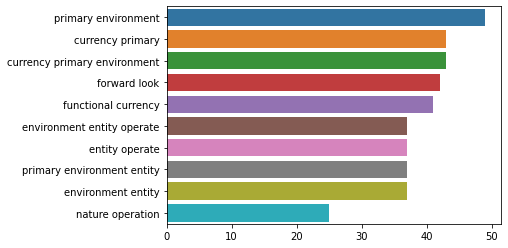

In [11]:
# filtering out the jargon
"""
word2remove = [
               'consolidated', 'asset', 'assets',
               'libaility', 'liabilities', 'organization',
               'statement', 'ltd', 'cid',
               'keyera', 'inc', 'kel',
               'rimbey', 'lude', 'kei',
               'krl', 'year', 'end'
]
"""
word2remove = [
               'company', 'financial', 'statement',
               'consolidated', 'asset', 'assets',
               'liability', 'liabilities', 'year',
               'end', 'economic'
]

final_text = filtered_data.text.apply(lambda x: re.sub(' +', ' ', re.sub('|'.join(word2remove), '', x)).strip())

## this is just to see which words or phrases to take out and consider as jargon
maxdf, mindf = 0.99, 0.01 # default: 1.0 and 1 
count_vectorizer = CountVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
get_top_k(final_text, count_vectorizer)

In [12]:
# finalizing the text data 
clean_data = filtered_data.copy()
clean_data.text = final_text
clean_data

,finalfilename,fileyear,rating_quarters,text
0,TSX_7376__Absolute Software Corp___Active____(...,2018,4.0,nature operation absolute software corporation...
1,TSX_7299__Acasta Enterprises Inc___Active____(...,2018,2.0,report result cad currency primary environment...
2,TSX_7319__AcuityAds Holdings Inc___Active____(...,2018,1.0,monitor stability customer environment operate...
3,TSX_6552__Aecon Group Inc___Active____(2018-12...,2018,3.0,unforeseen change nature cost
4,TSX_3669__AgJunction Inc___Active____(2018-12-...,2018,2.0,internal control management information system...
...,...,...,...,...
464,TSX_9999__Vivo Cannabis Inc___Active____(2015-...,2015,2.0,ifrs include cohesive set disclosure requireme...
465,TSX_6531__Wall Financial Corp___Active____(201...,2015,4.0,carry value amount receivable deposit hold tru...
466,TSX_1021__Wallbridge Mining Company Ltd___Acti...,2015,4.0,total equity nature operation go concern note ...
467,TSX_9999__Well Health Technologies Corp___Acti...,2015,4.0,deficit nature operation go concern note


## Performing LDA

To extract topics from each document within the corpus

### Full Dataset

We want to try topic modelling on the full dataset first to see if there are distinct topics within these environmental disclosures

In [37]:
# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(clean_data.text)
lda = LatentDirichletAllocation(n_components = 3, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118856  0.095983       1        1  40.716180
2     -0.168535  0.030427       2        1  32.741238
1      0.049680 -0.126410       3        1  26.542581, topic_info=                    Term       Freq      Total Category  logprob  loglift
112             currency  12.000000  12.000000  Default  30.0000  30.0000
155               entity   9.000000   9.000000  Default  29.0000  29.0000
393              primary   8.000000   8.000000  Default  28.0000  28.0000
394  primary environment   8.000000   8.000000  Default  27.0000  27.0000
113     currency primary   7.000000   7.000000  Default  26.0000  26.0000
..                   ...        ...        ...      ...      ...      ...
163  environment operate   2.486193   4.960004   Topic3  -5.1353   0.6358
361              operate   2.787637  11.407561   Topic3  -5.0209  -0.0827
226               global   2.416853  10.576199   Topic3  -5.1636  -0.1497
319               market   2.205858   4.761428   Topic3  -5.2550   0.5570
164        environmental   2.167506  10.966202   Topic3  -5.2725  -0.2948

[166 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
16        1  0.807698    activity
19        3  0.743538      affect
20        3  0.950823   agreement
21        3  0.664487         air
35        2  0.741380  assumption
...     ...       ...         ...
518       3  0.882701         use
519       1  0.644324       value
519       3  0.214775       value
524       1  0.728644       water
524       3  0.182161       water

[174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [38]:
# Showing the words for each topic
n_words_to_show = 8
fulldata_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
energy, environmental, global, nature, business, cost, provision, december

Topic 1:
environment, change, nature, base, time, segment, rate, regulatory

Topic 2:
currency, entity, primary, primary environment, environment, operate, currency primary, currency primary environment



In [39]:
# finding the topic classification for each observation
classified_data = topic_classification(lda, tfidf_fit, clean_data)
classified_data.groupby('rating_quarters').topic_labels.value_counts()

rating_quarters  topic_labels
1.0              0               65
                 2               33
                 1               24
2.0              0               67
                 2               28
                 1               20
3.0              0               67
                 2               26
                 1               20
4.0              0               67
                 2               40
                 1               12
Name: topic_labels, dtype: int64

In [40]:
classified_data.groupby('fileyear').topic_labels.value_counts()

fileyear  topic_labels
2015      0               62
          2               38
          1               13
2016      0               66
          2               38
          1               19
2017      0               73
          1               28
          2               26
2018      0               65
          2               25
          1               16
Name: topic_labels, dtype: int64

### Trying on rating 1 and 4

**Rating 1**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 1, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 4, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.084126  0.009609       1        1  33.868260
3      0.043231  0.046714       2        1  25.446578
2      0.024026 -0.036470       3        1  20.886793
0      0.016870 -0.019853       4        1  19.798369, topic_info=                          Term      Freq     Total Category  logprob  loglift
413    provision environmental  1.000000  1.000000  Default  30.0000  30.0000
334           nature operation  1.000000  1.000000  Default  29.0000  29.0000
116            cost production  0.000000  0.000000  Default  28.0000  28.0000
170       environmental permit  1.000000  1.000000  Default  27.0000  27.0000
455           risk uncertainty  1.000000  1.000000  Default  26.0000  26.0000
..                         ...       ...       ...      ...      ...      ...
454  responsibility management  0.332590  0.819629   Topic4  -5.2359   0.7176
369               orporate law  0.319087  0.810774   Topic4  -5.2774   0.6870
291                  long term  0.313439  0.862250   Topic4  -5.2952   0.6076
42            british columbia  0.307775  0.948657   Topic4  -5.3135   0.4939
3          accompany financial  0.294955  1.058600   Topic4  -5.3560   0.3417

[172 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
22        2  1.248507                        approximate fair
23        2  1.248507                  approximate fair value
28        1  1.080443                      assumption subject
29        1  1.080443             assumption subject inherent
54        1  0.878397                               cash flow
116       3  1.229410                         cost production
136       1  0.895439                              dep nature
137       1  1.032541                      dep nature purpose
159       1  1.091343                           energy energy
160       1  1.091343                      energy energy krpl
161       1  1.091343                             energy krpl
162       1  1.008964                              energy ome
165       1  0.940841                         energy services
170       1  0.720286                    environmental permit
171       1  0.718875            environmental rehabilitation
171       2  0.718875            environmental rehabilitation
173       2  1.043076  environmental rehabilitation provision
204       2  1.073935                              fair value
205       2  1.248507                        fair value short
208       1  1.013899                    financial instrument
209       2  0.892780                     financial liability
219       1  0.576958                            forward look
223       1  1.080443                    forward look require
237       2  1.238615                              go concern
257       1  0.924042                           inherent risk
258       1  0.924042               inherent risk uncertainty
259       1  0.845671                     initial recognition
297       1  1.080443                            look require
298       1  1.080443                 look require assumption
330       1  0.924042                          nature forward
331       1  0.924042                     nature forward look
334       3  0.824540                        nature operation
337       1  1.032541                          nature purpose
338       1  1.032541                nature purpose financial
413       1  0.680647                 provision environmental
414       1  0.922918  provision environmental rehabilitation
415       1  1.032541                       purpose financial
435       2  1.043076                rehabilitation provision
448       1  1.080443                      require assumption
449       1  1.080443              require assumption subject
455       1  0.725253                        risk uncert

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
rating_1_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
service business, go concern, nature operation go, operation go, operation go concern, short sea, nature operation, matter lack market

Topic 1:
cash flow, financial instrument, environmental permit, month end, energy services, december december, cost sale, end december december

Topic 2:
forward look, fair value, risk uncertainty, nature operation, forward look require, nature forward look, subject inherent, look require assumption

Topic 3:
environmental rehabilitation, provision environmental, provision environmental rehabilitation, environmental requirement, sustain ongoing, sustain ongoing production, ongoing production, financial liability



**Rating 4**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 4, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 4, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.064443 -0.031096       1        1  29.343870
1      0.007766  0.028894       2        1  25.986878
3      0.055537 -0.041009       3        1  24.793645
0      0.001140  0.043211       4        1  19.875606, topic_info=                         Term      Freq     Total Category  logprob  loglift
294          nature operation  1.000000  1.000000  Default  30.0000  30.0000
137            energy service  1.000000  1.000000  Default  29.0000  29.0000
197              global dairy  1.000000  1.000000  Default  28.0000  28.0000
406              total energy  0.000000  0.000000  Default  27.0000  27.0000
248                 long term  0.000000  0.000000  Default  26.0000  26.0000
..                        ...       ...       ...      ...      ...      ...
186  forward look information  0.328012  0.691843   Topic4  -5.0854   0.8694
224       initial recognition  0.417540  0.991686   Topic4  -4.8440   0.7507
378            services total  0.285343  0.580777   Topic4  -5.2247   0.9050
375          service business  0.339408  1.044186   Topic4  -5.0512   0.4919
181          financial result  0.334218  1.039404   Topic4  -5.0666   0.4811

[193 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
6         1  0.940772               accompany financial
21        1  1.155227         application environmental
22        1  1.155227  application environmental permit
35        1  1.206795                assumption subject
36        1  1.206795       assumption subject inherent
59        3  0.722653                         cash flow
137       4  0.901034                    energy service
139       4  0.880779                   energy services
148       1  0.800684              environmental permit
150       3  0.891799      environmental rehabilitation
152       1  0.936169         environmental requirement
181       1  0.962090                  financial result
184       1  0.599499                      forward look
184       3  0.599499                      forward look
190       3  1.242380                       future cash
191       3  1.242380                  future cash flow
192       3  0.975062                      future event
197       4  0.958516                      global dairy
198       3  1.006478                        go concern
218       1  1.206795                     inherent risk
219       1  1.206795         inherent risk uncertainty
248       4  1.052728                         long term
286       1  1.256120                    nature forward
287       1  1.256120               nature forward look
294       3  0.611660                  nature operation
296       3  1.006478               nature operation go
320       3  1.006478                      operation go
321       3  1.006478              operation go concern
370       1  0.961317                  risk uncertainty
375       1  0.957683                  service business
381       1  1.267620                        short term
382       1  1.267620                 short term nature
390       1  1.064840              social environmental
395       1  1.206795                  subject inherent
396       1  1.206795             subject inherent risk
406       4  1.016842                      total energy, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
rating_4_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
environmental rehabilitation, nature operation, provision environmental, rehabilitation provision, environmental rehabilitation provision, operation go, go concern, operation go concern

Topic 1:
purpose financial, initial recognition, depend nature, depend nature purpose, nature purpose, nature purpose financial, term nature, fair value

Topic 2:
global dairy, index etf, restoration rehabilitation, rehabilitation environmental, restoration rehabilitation environmental, financial position, constructive obligation ur, environmental cost

Topic 3:
forward look, environmental permit, total energy, financial result, risk uncertainty, inherent risk uncertainty, inherent risk, kei krl



**Comparison Summary**

In [ ]:
summary_layout(rating_1_words, 
               rating_4_words)

topic 0
service business, go concern, nature operation go, operation go, operation go concern, short sea, nature operation, matter lack market
environmental rehabilitation, nature operation, provision environmental, rehabilitation provision, environmental rehabilitation provision, operation go, go concern, operation go concern


topic 1
cash flow, financial instrument, environmental permit, month end, energy services, december december, cost sale, end december december
purpose financial, initial recognition, depend nature, depend nature purpose, nature purpose, nature purpose financial, term nature, fair value


topic 2
forward look, fair value, risk uncertainty, nature operation, forward look require, nature forward look, subject inherent, look require assumption
global dairy, index etf, restoration rehabilitation, rehabilitation environmental, restoration rehabilitation environmental, financial position, constructive obligation ur, environmental cost


topic 3
environmental rehabilit

Highly rated companies tend to show more concern about nature and have conversational topics about adjusting their progress to work around nature instead of over nature (trying to leave nature as it is). 

They also seem to talk about the environmental cost when talking about rehabilitation of the environment instead of it being a financial liability. I guess what we can deduce from this is that higher rated companies are earning more because of their evident priorities when looking at environmental issues. 

### Trying on the different years

**2015**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2015, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.006574  0.010218       1        1  22.804002
4      0.003277  0.002693       2        1  20.935020
0      0.006763 -0.011816       3        1  20.444748
2     -0.017627 -0.000270       4        1  20.156267
3      0.001012 -0.000825       5        1  15.659964, topic_info=                  Term      Freq     Total Category  logprob  loglift
1742  risk uncertainty  0.000000  0.000000  Default  30.0000  30.0000
1972       uncertainty  0.000000  0.000000  Default  29.0000  29.0000
859       forward look  0.000000  0.000000  Default  28.0000  28.0000
1170              look  0.000000  0.000000  Default  27.0000  27.0000
858            forward  0.000000  0.000000  Default  26.0000  26.0000
...                ...       ...       ...      ...      ...      ...
1294  nature operation  0.058180  0.305946   Topic5  -6.8996   0.1942
1250            mining  0.052800  0.233335   Topic5  -6.9966   0.3681
1393         operation  0.053602  0.340159   Topic5  -6.9815   0.0062
677             energy  0.053383  0.355853   Topic5  -6.9856  -0.0430
141         assumption  0.050897  0.306846   Topic5  -7.0333   0.0575

[271 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
year2015 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
december, end, corporation, nature, financial, month, month end, business

Topic 1:
energy, financial, company, service, nature, oil, contract, year

Topic 2:
risk uncertainty, uncertainty, look, forward, forward look, risk, subject inherent risk, look require assumption

Topic 3:
nexgen, nature, company, value, go, concern, go concern, infrastructure

Topic 4:
financial, note, lude, contingency, sustain, rease, production, law



**2016**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2016, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004444  0.013696       1        1  27.550214
2      0.014996 -0.002775       2        1  24.054132
1     -0.010328 -0.009941       3        1  20.084983
3     -0.000580 -0.000162       4        1  14.959980
4      0.000356 -0.000818       5        1  13.350691, topic_info=                         Term      Freq     Total Category  logprob  loglift
1442           rehabilitation  0.000000  0.000000  Default  30.0000  30.0000
527                    energy  0.000000  0.000000  Default  29.0000  29.0000
1368  provision environmental  0.000000  0.000000  Default  28.0000  28.0000
1541                   rimbey  0.000000  0.000000  Default  27.0000  27.0000
418                  december  0.000000  0.000000  Default  26.0000  26.0000
...                       ...       ...       ...      ...      ...      ...
1368  provision environmental  0.051813  0.213969   Topic5  -6.7124   0.5954
968                 liability  0.051801  0.223760   Topic5  -6.7126   0.5504
527                    energy  0.048062  0.317577   Topic5  -6.7875   0.1254
1361                provision  0.046403  0.246804   Topic5  -6.8227   0.3424
1090                   nature  0.047202  0.488174   Topic5  -6.8056  -0.3226

[254 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
year2016 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
nature, company, business, requirement, trevali, mining, customer, licence

Topic 1:
energy, lude, december, financial, month, end, expect, energy services

Topic 2:
nature, assumption, subject, require assumption subject, require assumption, subject inherent risk, subject inherent, forward look require

Topic 3:
reclamation, expenditure, reclamation expenditure charge, reclamation expenditure, charge provision, charge provision environmental, expenditure charge, expenditure charge provision

Topic 4:
environmental, rehabilitation, rimbey, legal, rehabilitation finance, rehabilitation finance liability, provision environmental rehabilitation, finance



**2017**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2017, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.018667  0.001853       1        1  26.341986
4      0.007288  0.011986       2        1  21.090942
0      0.003909 -0.010144       3        1  20.112724
2      0.004705 -0.001492       4        1  17.082362
3      0.002765 -0.002203       5        1  15.371986, topic_info=           Term      Freq     Total Category  logprob  loglift
740         etf  0.000000  0.000000  Default  30.0000  30.0000
650         end  0.000000  0.000000  Default  29.0000  29.0000
2200       year  0.000000  0.000000  Default  28.0000  28.0000
1254      month  0.000000  0.000000  Default  27.0000  27.0000
1255  month end  0.000000  0.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
818   financial  0.073293  0.404370   Topic5  -6.7669   0.1648
337     company  0.068578  0.422095   Topic5  -6.8334   0.0554
1805     result  0.055765  0.227016   Topic5  -7.0402   0.4688
1771     report  0.054883  0.218287   Topic5  -7.0562   0.4920
1273     nature  0.063500  0.469528   Topic5  -6.9103  -0.1281

[258 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
year2017 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
year, environmental, operation, nature, ore, corporation, iron, iron ore

Topic 1:
etf, energy, equity, index etf, robo, robotic, robotic automation, robotic automation index

Topic 2:
nature, company, financial, future, sale, financial liability, coffee, decaffeinate

Topic 3:
end, liability, december, month, month end, financial, short, corporation

Topic 4:
production, lude, audit, financial, environmental, environmental rehabilitation, environmental rehabilitation provision, rehabilitation provision



**2018**

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2018, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.017142 -0.001313       1        1  26.071933
2      0.008424 -0.009738       2        1  23.651851
0      0.005010  0.013378       3        1  22.535740
1      0.003624 -0.002061       4        1  18.300439
4      0.000085 -0.000266       5        1   9.440037, topic_info=                           Term      Freq     Total Category  logprob  loglift
723            financial result  0.000000  0.000000  Default  30.0000  30.0000
1588                     result  0.000000  0.000000  Default  29.0000  29.0000
471                    december  0.000000  0.000000  Default  28.0000  28.0000
1348                    prepare  0.000000  0.000000  Default  27.0000  27.0000
23                   accordance  0.000000  0.000000  Default  26.0000  26.0000
...                         ...       ...       ...      ...      ...      ...
1886                      value  0.030790  0.268973   Topic5  -6.9456   0.1928
561                      energy  0.032205  0.386430   Topic5  -6.9007  -0.1246
175                        base  0.028969  0.245127   Topic5  -7.0065   0.2247
43             acquire canadian  0.027926  0.159611   Topic5  -7.0432   0.6170
44    acquire canadian hydrovac  0.027926  0.159611   Topic5  -7.0432   0.6170

[268 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
year2018 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
provision, environmental, nature, time initial recognition, time initial, initial, initial recognition, recognition

Topic 1:
claim, environmental, corporation, prior, property, legal, unregistered, company

Topic 2:
energy, fund, nature, segment, ome, spark, novaalgoma, benefit

Topic 3:
december, financial, nature, cost, end, fair, fair value, value

Topic 4:
financial result, result, financial, base total, prepare, accordance, prepare accordance, prepare accordance ifrs



**Comparison Summary**

In [ ]:
summary_layout(year2015,
               year2016,
               year2017,
               year2018)

topic 0
december, end, corporation, nature, financial, month, month end, business
nature, company, business, requirement, trevali, mining, customer, licence
year, environmental, operation, nature, ore, corporation, iron, iron ore
provision, environmental, nature, time initial recognition, time initial, initial, initial recognition, recognition


topic 1
energy, financial, company, service, nature, oil, contract, year
energy, lude, december, financial, month, end, expect, energy services
etf, energy, equity, index etf, robo, robotic, robotic automation, robotic automation index
claim, environmental, corporation, prior, property, legal, unregistered, company


topic 2
risk uncertainty, uncertainty, look, forward, forward look, risk, subject inherent risk, look require assumption
nature, assumption, subject, require assumption subject, require assumption, subject inherent risk, subject inherent, forward look require
nature, company, financial, future, sale, financial liability, coffee, de

### Trying on the rating and the years

In [ ]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2015, :]
scoped_data = scoped_data.loc[scoped_data.rating_quarters == 4, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.012316 -0.004416       1        1  31.849544
2     -0.013549 -0.004450       2        1  22.398359
3      0.001443 -0.002568       3        1  22.160350
1     -0.000170  0.013398       4        1  15.740607
4     -0.000040 -0.001965       5        1   7.851140, topic_info=                            Term      Freq     Total Category  logprob  loglift
68   assumption subject inherent  0.000000  0.000000  Default  30.0000  30.0000
490      look require assumption  0.000000  0.000000  Default  29.0000  29.0000
707                      require  0.000000  0.000000  Default  28.0000  28.0000
708           require assumption  0.000000  0.000000  Default  27.0000  27.0000
709   require assumption subject  0.000000  0.000000  Default  26.0000  26.0000
..                           ...       ...       ...      ...      ...      ...
491                         lude  0.013342  0.231666   Topic5  -6.8443  -0.3099
420                      initial  0.013342  0.234891   Topic5  -6.8443  -0.3237
537             nature operation  0.013341  0.240502   Topic5  -6.8443  -0.3473
582                    operation  0.013341  0.240502   Topic5  -6.8443  -0.3473
284                       equity  0.013341  0.232090   Topic5  -6.8443  -0.3118

[260 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
year2015rating4 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
company, financial, energy, nature, rease, total energy, total, performance

Topic 1:
note, nature operation go, go concern, concern, go, concern note, operation go concern, operation go

Topic 2:
application, nature, company, fund, ifrs, capital, settlement, equity

Topic 3:
nexgen, company, financial, significant, ome tax, provision environmental, rehabilitation defer, defer

Topic 4:
subject, inherent, assumption subject inherent, look require, inherent risk uncertainty, inherent risk, forward look require, look require assumption

